In [5]:
%matplotlib inline

import os
import numpy as np
import pandas as pd

from tqdm import tqdm

# from pandas_utils import load_data, join_timestamp_per_gps_info
from pandas_utils import USE_GET_COLUMNS, USE_REQ_COLUMNS, DSME_WORK_STATION
from location_utils import check_gps_in_area
from shapely.geometry import Point, Polygon, mapping

### 데이터 불러오기

In [7]:
DATA_DIR = "data/고소차 Data/tele_car_get"
filenames = [os.path.join(DATA_DIR, filename) for filename in os.listdir(DATA_DIR)]

list_df = []
for filename in tqdm(filenames):
    list_df.append(pd.read_csv(filename))

df = pd.concat(list_df)
df

100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.72s/it]
C:\Users\design\.conda\envs\dsme\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Unnamed: 0,battery,dsme_lat,dsme_lon,dvc_id,ed_id,eqp_id,err_code,gps_lat,gps_lon,...,is_in_dock,is_moving,lot_no,msg_seq_num,req_no,seq_id,timestamp,tx_period_move,tx_period_stop,use_date
0,0,NaN,253617.342005,172933.088687,ITM.ELE_S0157,S0157,N-229,0,34.878154,128.703939,...,0.0,False,CQE201,1404,NaN,7906849,2020-01-01 00:00:00,2,2,20200101
1,1,NaN,253073.962485,174279.707804,ITM.ELE_S0449,S0449,N-313,0,34.873291,128.718685,...,0.0,False,NaN,42870,2.019123e+10,7906848,2020-01-01 00:00:00,2,2,20200101
2,2,NaN,253505.668541,173449.130466,ITM.ELE_S0059,S0059,N-630,0,34.877161,128.709587,...,0.0,False,NaN,44214,2.019122e+10,7906850,2020-01-01 00:00:02,2,2,20200101
3,3,NaN,253113.481230,172625.036648,ITM.ELE_S0149,S0149,N-499,0,34.873604,128.700586,...,0.0,False,A7W004,12489,2.019123e+10,7906854,2020-01-01 00:00:03,2,2,20200101
4,4,NaN,253120.148507,174227.722753,ITM.ELE_S0388,S0388,N-576,0,34.873706,128.718115,...,0.0,False,DMH003,51330,2.019122e+10,7906851,2020-01-01 00:00:03,2,2,20200101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119019,3119019,NaN,253495.755585,173120.243560,ITM.ELE_S0439,S0439,N-347,0,34.877063,128.705990,...,0.0,False,2DP203,51882,2.019122e+10,7906845,2019-12-31 23:59:57,2,2,20191231
3119020,3119020,NaN,253455.053960,173002.550148,ITM.ELE_S0441,S0441,N-414,0,34.876693,128.704704,...,0.0,False,2D0003,21262,2.019123e+10,7906844,2019-12-31 23:59:57,2,2,20191231
3119021,3119021,NaN,253373.166883,172744.850521,ITM.ELE_S0415,S0415,N-618,0,34.875948,128.701888,...,0.0,False,NaN,57106,2.019122e+10,7906847,2019-12-31 23:59:58,2,2,20191231
3119022,3119022,NaN,253617.342005,172933.088687,ITM.ELE_S0157,S0157,N-229,0,34.878154,128.703939,...,0.0,False,CQE201,1404,NaN,7906849,2020-01-01 00:00:00,2,2,20200101


In [8]:
sample_df = df[['eqp_id', 'gps_lat', 'gps_lon', 'timestamp', 'is_generator_on', 'req_no', 'use_date']].copy()
sample_df

,eqp_id,gps_lat,gps_lon,timestamp,is_generator_on,req_no,use_date
0,N-229,34.878154,128.703939,2020-01-01 00:00:00,False,NaN,20200101
1,N-313,34.873291,128.718685,2020-01-01 00:00:00,False,2.019123e+10,20200101
2,N-630,34.877161,128.709587,2020-01-01 00:00:02,False,2.019122e+10,20200101
3,N-499,34.873604,128.700586,2020-01-01 00:00:03,False,2.019123e+10,20200101
4,N-576,34.873706,128.718115,2020-01-01 00:00:03,False,2.019122e+10,20200101
...,...,...,...,...,...,...,...
3119019,N-347,34.877063,128.705990,2019-12-31 23:59:57,False,2.019122e+10,20191231
3119020,N-414,34.876693,128.704704,2019-12-31 23:59:57,False,2.019123e+10,20191231
3119021,N-618,34.875948,128.701888,2019-12-31 23:59:58,True,2.019122e+10,20191231
3119022,N-229,34.878154,128.703939,2020-01-01 00:00:00,False,NaN,20200101


In [10]:
for col in sample_df.columns:
    print (col, ": ", sum(sample_df[col].isna()), ' / ', len(sample_df))

eqp_id :  326670  /  14642105
gps_lat :  0  /  14642105
gps_lon :  0  /  14642105
timestamp :  0  /  14642105
is_generator_on :  0  /  14642105
req_no :  1868869  /  14642105
use_date :  0  /  14642105


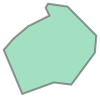

In [11]:
dsme_work_station = Polygon(DSME_WORK_STATION)
dsme_work_station

In [15]:
available_gps = []
for y, x in tqdm(sample_df[['gps_lat', 'gps_lon']].values):
    available_gps.append(check_gps_in_area(y, x, dsme_work_station))

100%|████████████████████████████████████████████████████| 14642105/14642105 [11:06<00:00, 21963.55it/s]


In [17]:
print('유효 gps : {}개 \n무효 gps : {}개'.format(available_gps.count(True), available_gps.count(False)))

유효 gps : 14633860개 
무효 gps : 8245개


In [18]:
sample_df = sample_df[available_gps]

In [20]:
sample_df.to_csv("11월~03월_get_data.csv")